In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# print(dir())
# print(open)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    print(data.shape)
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将3组输入数据依次向下移动3，2，1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有四块经过下移后的数据(即：df(-3),df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def clean_data(file_path, start_row, end_row):
    # 读取xls文件
    df = pd.read_excel(file_path, skiprows=start_row, nrows=end_row-start_row)
    # 如果有NaN值，使用特定值填充，例如0或平均值
    df.fillna(0, inplace=True)
    # 可以在这里添加更多数据清洗步骤
    return df
# 指定要读取的列名
columns = ['开盘', '最高', '最低', '收盘', '成交量', '成交额', '日涨跌', '日涨跌幅', 'k值', '10日涨幅', 'OBV', '10日涨跌比', '10日相对强弱指标', '12日乖离值', '9日RSV']

# 指定数据文件路径
file_path = 'HSI_日线数据+factor.xls'

# 使用pandas的read_excel函数读取.xls文件，仅获取需要的列
data = pd.read_excel(file_path, usecols=columns)
# 根据需要选择特定行，假设我们想要从第15行到第7244行的数据（索引从0开始，所以减1）
start_row = 15
end_row = 7244
data = data.iloc[start_row:end_row]
# print(data.iloc[-735:,:])
# row_7246 = data.iloc[7240]
# print(row_7246)
# 输出结果以确认
print(data.head())
values=data.values


         开盘       最高       最低       收盘  成交量  成交额     日涨跌      日涨跌幅   k值  \
15  9695.03  9749.70  9628.64  9695.03    0  0.0   11.35  0.001172  0.0   
16  9585.89  9795.88  9583.40  9585.89    0  0.0 -109.14 -0.011257  0.0   
17  9642.85  9686.07  9508.73  9642.85    0  0.0   56.96  0.005942  0.0   
18  9602.21  9630.79  9562.41  9602.21    0  0.0  -40.64 -0.004215  0.0   
19  9537.87  9631.77  9534.65  9537.87    0  0.0  -64.34 -0.006701  0.0   

       10日涨幅  OBV  10日涨跌比  10日相对强弱指标    12日乖离值     9日RSV  
15  0.043212  0.0     8.0        0.9  0.028587  8.109704  
16  0.057601  0.0     3.5        0.8  0.031085  9.037340  
17  0.049079  0.0     8.0        0.9  0.022204  8.216406  
18  0.039593  0.0     3.5        0.8  0.011645  6.861006  
19  0.027416  0.0     2.0        0.7 -0.001761  1.511012  


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 用3天数据预测一天数据，15个特征值
n_days = 3  ###在这里调整前置几天，也就是步长
n_features = 15
# 构造一个3->1的监督学习型数据
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed)


(7229, 15)
      var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3      0.114126   0.108694   0.117024   0.114541   0.000000   0.000000   
4      0.110037   0.110428   0.115307   0.110421   0.000000   0.000000   
5      0.112171   0.106305   0.112474   0.112571   0.000000   0.000000   
6      0.110648   0.104229   0.114511   0.111037   0.000000   0.000000   
7      0.108237   0.104265   0.113457   0.108609   0.000000   0.000000   
...         ...        ...        ...        ...        ...        ...   
7224   0.403075   0.408360   0.410129   0.415333   0.252086   0.252073   
7225   0.422097   0.419945   0.430876   0.426749   0.319378   0.319376   
7226   0.419738   0.414413   0.421752   0.415561   0.248510   0.248507   
7227   0.412240   0.409267   0.417134   0.411722   0.261042   0.261031   
7228   0.408596   0.404148   0.414090   0.409564   0.208834   0.208833   

      var7(t-3)  var8(t-3)  var9(t-3)  var10(t-3)  ...   var6(t)   var7(t)  \
3      0.471709   0.42

In [6]:
values = reframed.values
n_test = 735
train = values[:-n_test, :]
test = values[-n_test:, :]
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -12]
test_X, test_y = test[:, :n_obs], test[:, -12] 
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6491, 3, 15) (6491,) (735, 3, 15) (735,)




Epoch 1/520

91/91 - 3s - loss: 0.0744 - val_loss: 0.0650 - 3s/epoch - 30ms/step
Epoch 2/520
91/91 - 0s - loss: 0.0605 - val_loss: 0.0449 - 352ms/epoch - 4ms/step
Epoch 3/520
91/91 - 0s - loss: 0.0421 - val_loss: 0.0280 - 336ms/epoch - 4ms/step
Epoch 4/520
91/91 - 0s - loss: 0.0235 - val_loss: 0.0219 - 362ms/epoch - 4ms/step
Epoch 5/520
91/91 - 0s - loss: 0.0136 - val_loss: 0.0103 - 351ms/epoch - 4ms/step
Epoch 6/520
91/91 - 0s - loss: 0.0097 - val_loss: 0.0075 - 364ms/epoch - 4ms/step
Epoch 7/520
91/91 - 0s - loss: 0.0095 - val_loss: 0.0078 - 348ms/epoch - 4ms/step
Epoch 8/520
91/91 - 0s - loss: 0.0093 - val_loss: 0.0064 - 365ms/epoch - 4ms/step
Epoch 9/520
91/91 - 0s - loss: 0.0074 - val_loss: 0.0078 - 349ms/epoch - 4ms/step
Epoch 10/520
91/91 - 0s - loss: 0.0086 - val_loss: 0.0102 - 350ms/epoch - 4ms/step
Epoch 11/520
91/91 - 0s - loss: 0.0124 - val_loss: 0.0075 - 354ms/epoch - 4ms/step
Epoch 12/520
91/91 - 0s - loss: 0.0109 - val_loss: 0.0087 - 359ms/epoch - 4ms/step
Epoch 13/520

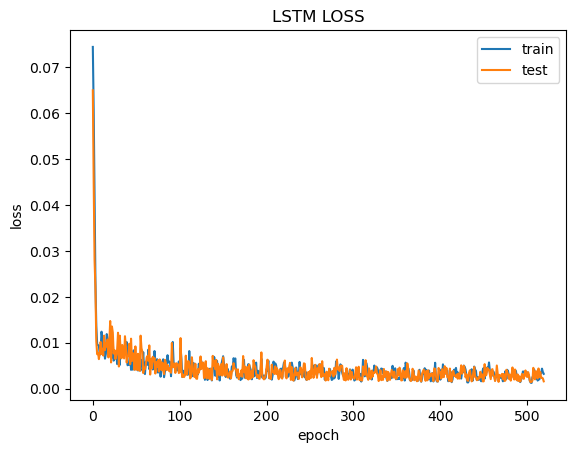

In [7]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
plt.title('LSTM LOSS', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
pyplot.legend()
pyplot.show()

In [8]:
yhat = model.predict(test_X)

23/23 [==============================] - 0s 2ms/step


In [9]:

test_X = test_X.reshape((test_X.shape[0], n_days*n_features))


inv_yhat = concatenate((yhat, test_X[:, -15:-1]), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# print(inv_yhat)

# 读取原始的Excel文件
file_path = 'HSI_日线数据+factor.xls'
data = pd.read_excel(file_path)

# 截取第16行到第7246行的数据（Python索引从0开始）
selected_data = data.iloc[start_row:end_row]

# 假设 n_test 是测试集的大小，这里是最后的735行
# 那么，我们需要从selected_data的末尾截取对应数量的行以匹配预测结果
test_data = selected_data.iloc[-n_test:]

# 假设 inv_yhat 包含测试集的预测结果，长度与test_data相匹配
test_data['predict'] = inv_yhat

# 将更新后的DataFrame保存到新的Excel文件中
new_file_path = 'HSI_日线数据_with_predict.xlsx'
test_data.to_excel(new_file_path, index=False)

(735, 15)


C:\Users\epiph\AppData\Local\Temp\ipykernel_22268\3892773653.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predict'] = inv_yhat


In [10]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -15:-1]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# print(inv_y)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 55.027


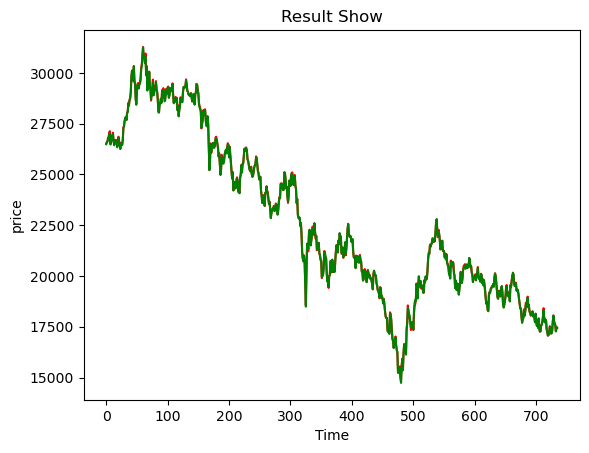

In [11]:
import matplotlib.pyplot as plt
plt.plot(inv_yhat,color='red',label="prediction")
plt.plot(inv_y,color="green",label="real")
plt.title("Result Show")
plt.xlabel("Time")
plt.ylabel("price")
plt.show()

In [13]:
# from datetime import datetime
# pre_data=data[-n_test:]
# pre_data['pre']=inv_yhat
# pre_data['date']=pre_data[-n_test:]

# pre_data['weekday']=pre_data['date'].apply(lambda x:datetime.strptime(x,"%Y-%m-%d").weekday())


In [ ]:
# from nose.util import tolist
# date = tolist(pre_data["date"])
# close_pre = tolist(pre_data["pre"])
# close = tolist(pre_data["收盘"])
# open_prices = tolist(pre_data["开盘"])
# week = tolist(pre_data["weekday"])
# print(date)
# print(week)

In [ ]:
# # 计算年化收益率与最大回撤率
# earn = 0
# max_asset = 0  # 最大资产
# max_d = 0  # 最大资产回落
# day = 0  # 投资天数
# num = 0

# # 初始资金为100000
# init = 1000000
# remain = init

# # 把初始仓位设为0
# position = 0
# day_vol=[]

In [ ]:
# for i in range(3, len(close_pre)):
#     # 投资天数加一
#     day += 1
#     cur_asset = remain + num * float(open_prices[i])
#     day_vol.append(cur_asset)
#     if cur_asset > max_asset:
#         max_asset = cur_asset
#     elif max_asset - cur_asset > max_d:
#         max_d = max_asset - cur_asset
#     # 若没有仓位，当天为星期一，且预测值为上涨，则开仓
#     # 用预测值做决策，调整参数使收益最大，把决策直接用在实际值上计算收益
#     if position == 0 and float(close_pre[i]) > float(close_pre[i - 3]) and week[i] ==0:
#         num = int(init / float(close[i]))
#         remain -= float(close[i]) * num
#         position = (init - float(remain)) / init

#     # 当涨幅大于10%,平掉所有仓位
#     elif position != 0 and float(close_pre[i]) / float(close_pre[i - 1]) >= 1.1:
#         remain += float(close[i]) * num
#         init = remain
#         num = 0
#         position = 0

#     # 当跌幅大于0.7%，平掉所有的仓位
#     elif position != 0 and (float(close_pre[i - 1]) - float(close_pre[i])) / float(close_pre[i - 1]) > 0.004:
#         remain += float(close[i]) * num
#         init = remain
#         num = 0
#         position = 0
#     if date[i] == "2021-11-17" or date[i] == "2022-11-17" or date[i] == "2023-11-17":
#         cur_asset = remain + num * float(open_prices[i])
#         earn = cur_asset - 1000000
#         y_EarnR = (earn / 1000000) / (day / 365)
#         print('年化收益率: {:.2%}'.format(y_EarnR))
#         maxback = max_d / max_asset
#         print('最大回撤率: {:.2%}'.format(maxback))

# remain += float(close[-1]) * num
# print(remain)
# day += 1
# earn = remain - 1000000
# y_EarnR = (earn / 1000000)/ (day / 365)
# print('年化收益率: {:.2%}'.format(y_EarnR))
# maxback = max_d / max_asset
# print('最大回撤率: {:.2%}'.format(maxback))

In [ ]:
# plt.scatter(x=[i for i in range(len(day_vol))],y=day_vol,marker="."
# )
# plt.grid()